In [1]:
# importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import special, stats

# preprocessing
from sklearn.preprocessing import LabelEncoder

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# SMOTe
from imblearn.over_sampling import SMOTE

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 

# metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, average_precision_score, precision_recall_curve 
from sklearn.metrics import recall_score, roc_curve, roc_auc_score, precision_recall_curve, auc, plot_confusion_matrix

# ensemble
from xgboost import XGBClassifier

# warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# reading data
df = pd.read_csv('Dataset.txt', sep="\t", header=0, low_memory=False, dtype={'C':'int'}, index_col='Index')
df.shape # 101180 rows x 23 columns
# df.columns

(101180, 23)

In [3]:
# setting max display of table to avoid truncation
pd.options.display.max_columns = None
pd.options.display.max_rows = None

df.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,C
Index,,,,,,,,,,,,,,,,,,,,,,,
1,0.224506,0.500340,0.489860,0.902413,7934,-6970,-5714,9982,-5697,4227810299,-3918676258,316195953,6176861823,-3433637453,10/4/1986,9/6/1992,2,1,706,305,1,2,0
2,0.321128,0.281119,0.907283,0.772159,-8238,1219,1663,1287,-3658,-1146724819,-6837090439,1378635942,-9031507610,609277486,2/24/1979,1/5/1983,1,1,423,206,18,7,1
3,0.893441,0.622005,0.998776,0.098386,8540,5266,-9377,-3504,-4511,5947184989,6881163164,-9921889287,-5610051842,-8977995005,1/12/1989,11/22/1986,2,1,703,315,1,4,0
4,0.320641,0.957234,0.346000,0.646479,-7772,-383,9681,-8661,3474,-5724795826,-6014104498,6550322883,-4697085930,4868760308,2/18/1982,6/10/1992,1,1,122,304,15,1,0
5,0.475961,0.623008,0.544988,0.159709,1571,-8039,-7961,-2385,4407,-3097637172,-9755731483,759031103,9984692447,9757408267,4/10/1987,10/19/1985,1,1,486,240,1,1,0



#### Learnings:

__F1 F2 F3 F4__          are numbers lying from 0 to 1 <br>
__F5 F6 F7 F8 F9__       are 4 digit integers <br>
__F10 F11 F12 F13 F14__  are large integers <br>
__F15 F16__              are dates<br>
__F17 F18 F21 F22__      are categorical features<br>
__F19 F20__              are 3 digit numbers<br>

#### Assumptions:

__0__ is product __not__ purchased <br>
__1__ is product purchased


In [4]:
# Check for null values if any

# This method shows the count of null values, percent and dataTypes

def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
        
    tt['Types'] = types
    return(np.transpose(tt))

missing_data(df)

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,C
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Types,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,object,int64,int64,int64,int64,int64,int64,int32


#####  Result: We did not find any null values for the columns present in the dataset

In [5]:
# We find that most of the data is skewed
df.describe()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F17,F18,F19,F20,F21,F22,C
count,101180.000000,101180.000000,101180.000000,101180.000000,101180.000000,101180.000000,101180.000000,101180.000000,101180.000000,1.011800e+05,1.011800e+05,1.011800e+05,1.011800e+05,1.011800e+05,101180.000000,101180.000000,101180.000000,101180.000000,101180.000000,101180.000000,101180.000000
mean,0.502348,0.501497,0.499886,0.499839,-29.742617,1.511000,7.939118,16.434147,9.927812,1.869749e+07,-7.052456e+06,6.921685e+06,1.127538e+07,-5.198163e+07,1.339593,1.335027,387.181479,387.333999,4.588031,4.598567,0.245375
std,0.288058,0.289017,0.288875,0.288729,5781.829379,5796.594007,5765.581875,5782.805211,5771.004738,5.769064e+09,5.779111e+09,5.771750e+09,5.786659e+09,5.782358e+09,0.894065,0.882435,235.939585,235.374285,4.775671,4.776494,0.430311
min,0.000018,0.000004,0.000002,0.000006,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-9.999816e+09,-9.999804e+09,-9.999754e+09,-9.999852e+09,-9.999767e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,0.253819,0.251115,0.248818,0.250501,-5045.000000,-5012.000000,-4979.000000,-4988.000000,-4992.250000,-4.966961e+09,-4.994511e+09,-4.991278e+09,-5.027003e+09,-5.070403e+09,1.000000,1.000000,187.000000,187.000000,1.000000,1.000000,0.000000
50%,0.501802,0.501095,0.499820,0.501387,-46.000000,-11.500000,16.500000,60.000000,22.500000,4.346691e+07,-5.477172e+07,4.277384e+07,9.416236e+06,-8.816174e+07,1.000000,1.000000,374.000000,375.000000,3.000000,3.000000,0.000000
75%,0.753598,0.752404,0.750281,0.748803,4978.000000,5050.000000,4962.000000,5021.000000,5020.000000,5.019440e+09,4.994296e+09,5.008238e+09,5.032947e+09,4.947133e+09,1.000000,1.000000,560.000000,561.000000,7.000000,7.000000,0.000000
max,0.999986,0.999990,0.999985,0.999977,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,9.999497e+09,9.999897e+09,9.999555e+09,9.999951e+09,9.999997e+09,6.000000,6.000000,901.000000,901.000000,21.000000,21.000000,1.000000


In [6]:
df.skew(axis = 0, skipna = True) 
# If skewness is less than -1 or greater than 1, the distribution is highly skewed. 
# If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed. 
# If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.

F1    -0.005717
F2    -0.005972
F3     0.000252
F4    -0.000546
F5     0.008295
F6    -0.001068
F7    -0.001071
F8    -0.008812
F9    -0.002941
F10   -0.003904
F11    0.009654
F12   -0.004498
F13   -0.000964
F14    0.009208
F17    3.615808
F18    3.627241
F19    0.223636
F20    0.216100
F21    1.679967
F22    1.680833
C      1.183471
dtype: float64

<Figure size 432x288 with 0 Axes>

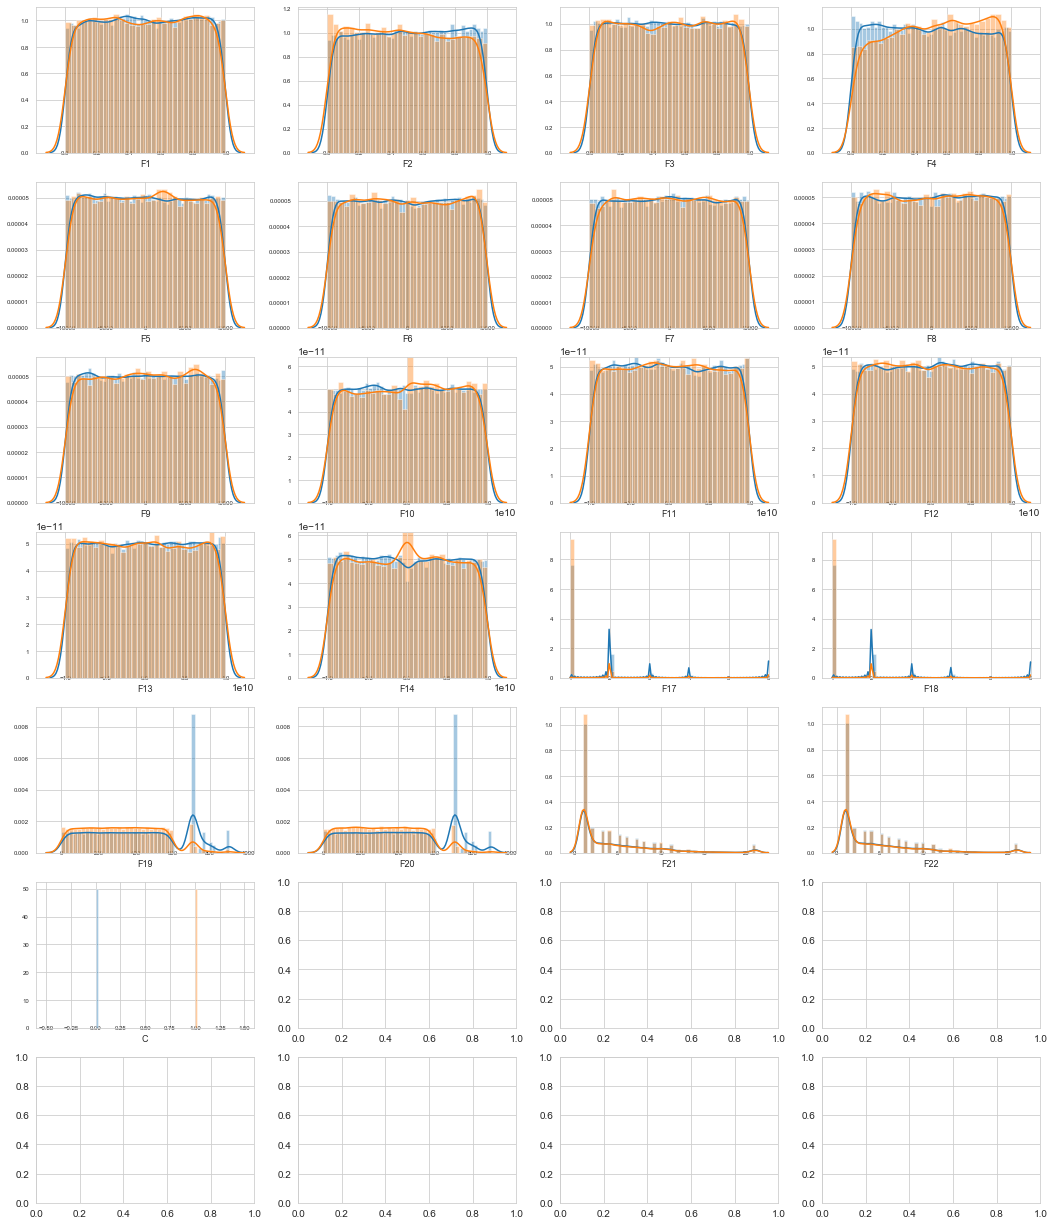

In [7]:
# We will try to visualise skewness here
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(7,4,figsize=(18,22))

    for feature in features:
        if feature in ('F15', 'F16'):
            pass
        else:
            
            i += 1
            plt.subplot(7,4,i)

            sns.distplot(df1[feature], hist=True, label=label1)
            sns.distplot(df2[feature], hist=True, label=label2)

            plt.xlabel(feature, fontsize=9)
            locs, labels = plt.xticks()

            plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
            plt.tick_params(axis='y', which='major', labelsize=6)
    
    plt.show()


t0 = df.loc[df['C'] == 0]
t1 = df.loc[df['C'] == 1]
features = df.columns.values

plot_feature_distribution(t0, t1, '0', '1', features)

##### We observe that all numerical features 
##### except F17, F18, F19, F20, F21, F22 
##### show uniform distribution 

In [8]:
# converting date columns to date type
df['F15'] = pd.to_datetime(df['F15']) 
df['F16'] = pd.to_datetime(df['F16']) 

In [9]:
# checking if F15 and F16 are start or end date
# is F15 always before F16 or vice versa ?
df15gt16 = df[df['F15'] >= df['F16']]
df15lt16 = df[df['F15'] < df['F16']]

print(len(df15gt16), len(df15lt16))
# 27909 73271
# hence the date features are not correponding to each other

# Ensuring we did not miss any record by doing the bifurcation
len(df15gt16) + len(df15lt16) == len(df)


27909 73271


True

In [10]:
# Univariate Analysis

# weekday analysis

weekday_f15 = pd.concat([df['F15'].dt.dayofweek, df['C']],axis=1)
weekday_f16 = pd.concat([df['F16'].dt.dayofweek, df['C']],axis=1)
weekday_f15.head()

,F15,C
Index,,
1,5,0
2,5,1
3,3,0
4,3,0
5,4,0


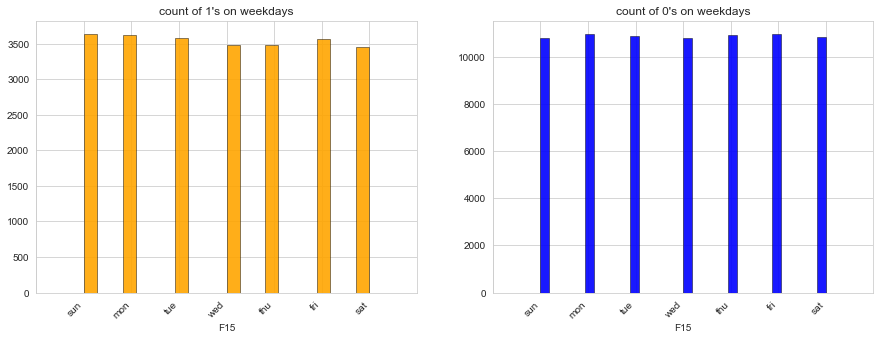

In [11]:
# is the value of target affected by weekday ?
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("count of 1\'s on weekdays")
sns.distplot(weekday_f15[weekday_f15.C==1]['F15'], hist_kws={'color':'orange',
                                                     'edgecolor':'black',
                                                     'linewidth':0.5, 
                                                     'linestyle':'-', 
                                                     'alpha':0.9}, kde=False)
locs, labels = plt.xticks()
x_ticks = []
new_xticks = ["", "sun", "mon", "tue", "wed", "thu", "fri", "sat"]
plt.xticks(locs, new_xticks, rotation=45, horizontalalignment='right')

plt.subplot(1,2,2)
plt.title("count of 0\'s on weekdays")
sns.distplot(weekday_f15[weekday_f15.C==0]['F15'], hist_kws = {'color':'blue', 
                                                      'edgecolor':'black',
                                                       'linewidth':0.5, 
                                                       'linestyle':'-', 
                                                       'alpha':0.9}, kde=False)
locs, labels=plt.xticks()
x_ticks = []
new_xticks = ["", "sun", "mon", "tue", "wed", "thu", "fri", "sat"]
plt.xticks(locs, new_xticks, rotation=45, horizontalalignment='right')
plt.show()

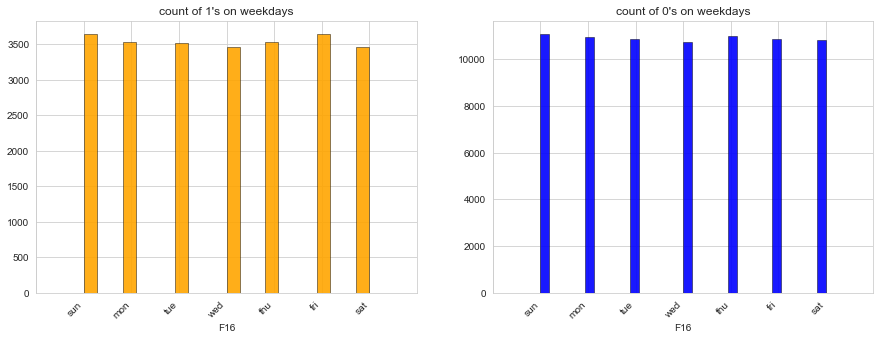

In [12]:
# we check the same thing for f16
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("count of 1\'s on weekdays")
sns.distplot(weekday_f16[weekday_f16.C==1]['F16'], hist_kws={'color':'orange',
                                                     'edgecolor':'black',
                                                     'linewidth':0.5, 
                                                     'linestyle':'-', 
                                                     'alpha':0.9}, kde=False)
locs, labels = plt.xticks()
x_ticks = []
new_xticks = ["", "sun", "mon", "tue", "wed", "thu", "fri", "sat"]
plt.xticks(locs, new_xticks, rotation=45, horizontalalignment='right')

plt.subplot(1,2,2)
plt.title("count of 0\'s on weekdays")
sns.distplot(weekday_f16[weekday_f16.C==0]['F16'], hist_kws = {'color':'blue', 
                                                      'edgecolor':'black',
                                                       'linewidth':0.5, 
                                                       'linestyle':'-', 
                                                       'alpha':0.9}, kde=False)
locs, labels=plt.xticks()
x_ticks = []
new_xticks = ["", "sun", "mon", "tue", "wed", "thu", "fri", "sat"]
plt.xticks(locs, new_xticks, rotation=45, horizontalalignment='right')
plt.show()

In [13]:
df['year_f15'] = df['F15'].dt.year
df['month_f15'] = df['F15'].dt.month
df['week_f15'] = df['F15'].dt.week
df['day_f15'] = df['F15'].dt.day_name()

le = LabelEncoder()
df['month_f15'] = le.fit_transform(df['month_f15'])
df['day_f15'] = le.fit_transform(df['day_f15'])

df['year_f16'] = df['F16'].dt.year

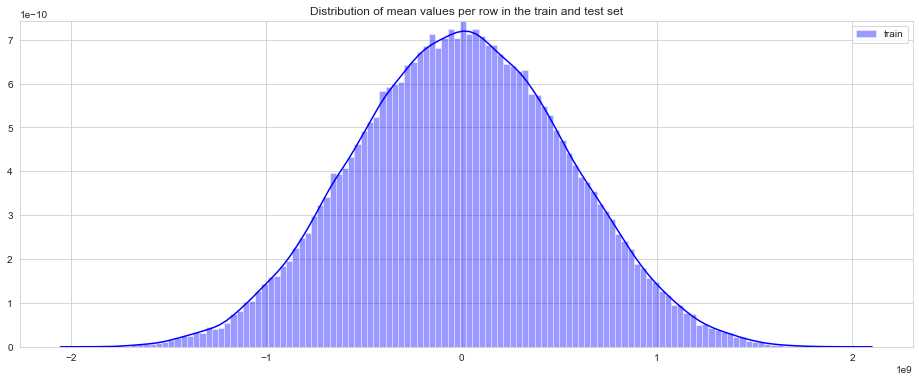

In [14]:
# Distribution of mean and standard deviation
plt.figure(figsize=(16,6))
features = df.columns.values[2:202]
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(df[features].mean(axis=1),color="blue", kde=True,bins=120, label='train')
plt.legend()
plt.show()

Proportion:  3.1 :1
There is a mild imbalance -- We have 3 records for class 0 for every one record of class 1


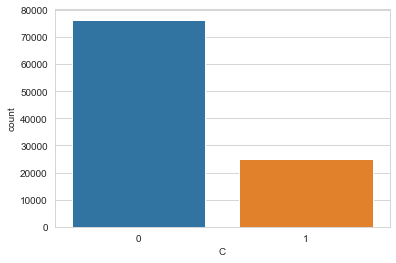

In [15]:
# Distrbution of the target variable

# Variable ‘C’ is specifying whether the 
# customers bought a specific product or not.

sns.countplot(df['C'])
target_counts = df.C.value_counts()
print("Proportion: ", round(target_counts[0] / target_counts[1], 1), ":1")
print("There is a mild imbalance -- We have 3 records for class 0 for every one record of class 1")
# class is distributed as 3:1 -- Imbalanced

In [16]:
df.columns

Index(['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11',
       'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21',
       'F22', 'C', 'year_f15', 'month_f15', 'week_f15', 'day_f15', 'year_f16'],
      dtype='object')

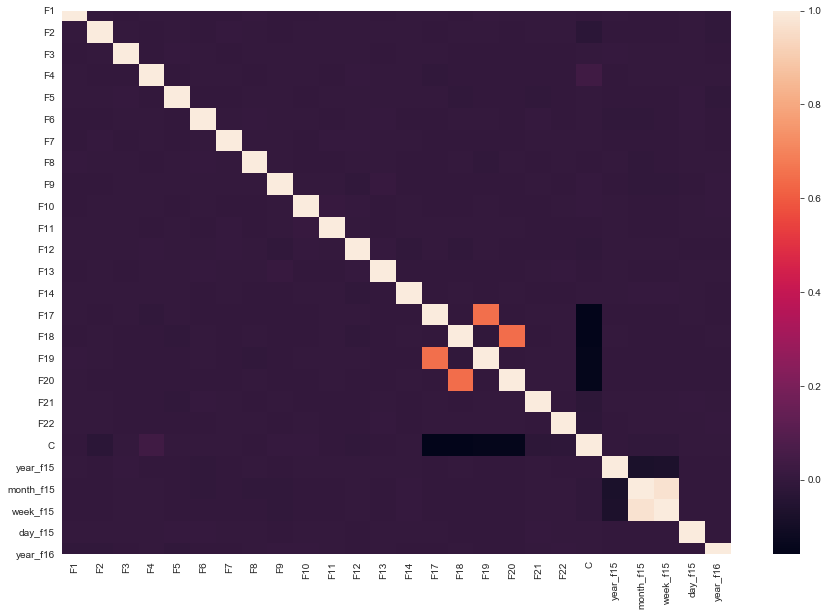

In [17]:
# Bivariate Analysis

# checking correlation of the dataframe
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr())
plt.show()

##### correlation matrix shows that `F17` is moderately correlated  to `F19`
##### correlation matrix shows that `F18` is moderately correlated to `F20`

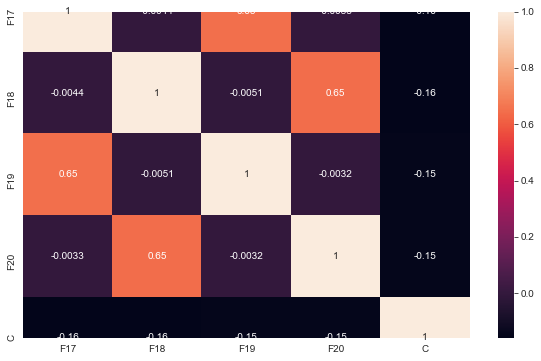

In [18]:
# We can drop either F17, F18 or F19, F20
# We will check the relationship of the pairs with C`

plt.figure(figsize=(10, 6))
sns.heatmap(df[['F17','F18','F19','F20', 'C']].corr()#.abs()
            , annot=True)
plt.show()

##### Although there is not much difference, `F17,F18` pair has a higher negative correlation
##### So we will go ahead and drop `F19, F20`. We will hold the variables for now and revisit 
##### this below 

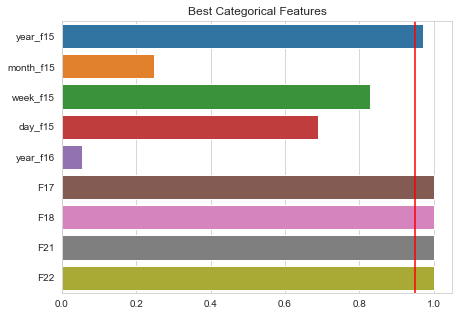

In [19]:
# we will now use chi square test of independence 
# to check which categorical variables are significant

from scipy.stats import chi2_contingency

l=[]
categorical=['year_f15', 'month_f15', 'week_f15', 'day_f15', 'year_f16','F17','F18','F21','F22']

for i in categorical:
    pvalue  = chi2_contingency(pd.crosstab(df['C'],df[i]))[1]
    l.append(1-pvalue)
    
plt.figure(figsize=(7,5))
sns.barplot(x=l, y=categorical)
plt.title('Best Categorical Features')
plt.axvline(x=(1-0.05),color='r')
plt.show()

#### chi square test of independence
#### this is showing acceptance of alternative hypothesis, we will be shortlisting the features crossing the line

#### Best categorical features which are statistically significant
__year_f15 F17 F18 F21 F22__

In [20]:
# Numerical features extraction
numerical_cols = ['F' + str(i) for i in range(1,15)]
numerical_cols.append('F19')
numerical_cols.append('F20')

numerical_cols

['F1',
 'F2',
 'F3',
 'F4',
 'F5',
 'F6',
 'F7',
 'F8',
 'F9',
 'F10',
 'F11',
 'F12',
 'F13',
 'F14',
 'F19',
 'F20']

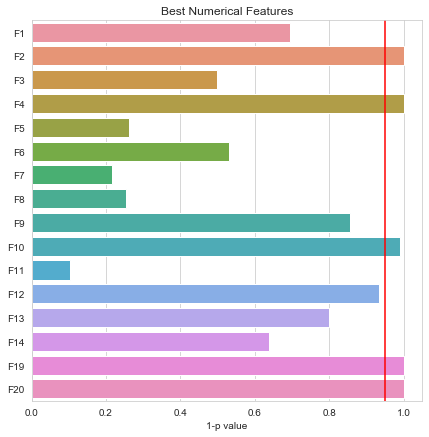

In [21]:
# we will now use t-test on numerical features to observe 
# if there is any difference between the means of two classes

from scipy.stats import ttest_ind

p=[]


for i in numerical_cols:
    df1 = df.groupby(by='C').get_group(0)
    df2 = df.groupby(by='C').get_group(1)
    
    t, pvalue = ttest_ind(df1[i], df2[i])
    p.append(1-pvalue)
    
plt.figure(figsize=(7, 7))
sns.barplot(x=p, y=numerical_cols)
plt.title('Best Numerical Features')
plt.axvline(x=(1-0.05), color='r')
plt.xlabel('1-p value')
plt.show()



##### Best numerical features which are statistically significant F2 F4 F10 F19  F20

##### null hypothesis: u1 an u2 are not different
##### alternate hypothesis: They are different

##### significant variable will show greater difference between the means of the two groups
##### hence predicitve power of the features crossing the red mark is `significant`

#### dropping insigficant features

In [22]:
sgfnt_num_feats = ['F2','F4','F10','F19','F20']
sgfnt_cat_feats = ['year_f15','F17','F18','F21','F22']

not_sgfnt = [
    col 
    for col in df.columns 
    if col not in sgfnt_num_feats 
    and col not in sgfnt_cat_feats
    and col != 'C'
]

not_sgfnt
df=df.drop(not_sgfnt, axis=1)
df.head()

,F2,F4,F10,F17,F18,F19,F20,F21,F22,C,year_f15
Index,,,,,,,,,,,
1,0.500340,0.902413,4227810299,2,1,706,305,1,2,0,1986
2,0.281119,0.772159,-1146724819,1,1,423,206,18,7,1,1979
3,0.622005,0.098386,5947184989,2,1,703,315,1,4,0,1989
4,0.957234,0.646479,-5724795826,1,1,122,304,15,1,0,1982
5,0.623008,0.159709,-3097637172,1,1,486,240,1,1,0,1987


#### Evaluating the feature importance using RandomForest

In [23]:
target = 'C'
feature_cols = [cols for cols in df.columns if cols != 'C']
feature_cols

['F2', 'F4', 'F10', 'F17', 'F18', 'F19', 'F20', 'F21', 'F22', 'year_f15']

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101180 entries, 1 to 101180
Data columns (total 11 columns):
F2          101180 non-null float64
F4          101180 non-null float64
F10         101180 non-null int64
F17         101180 non-null int64
F18         101180 non-null int64
F19         101180 non-null int64
F20         101180 non-null int64
F21         101180 non-null int64
F22         101180 non-null int64
C           101180 non-null int32
year_f15    101180 non-null int64
dtypes: float64(2), int32(1), int64(8)
memory usage: 13.9 MB


In [25]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(df[feature_cols],df[target])

RandomForestClassifier()

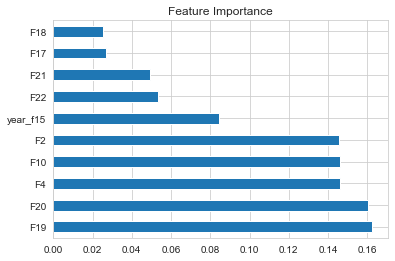

In [26]:
feat_importances = pd.Series(rfc.feature_importances_, index=feature_cols)
feat_importances.nlargest(10).plot(kind='barh', title='Feature Importance')

##### F19 and F20 are two most important features 

##### Calculating permutation importance beacuse the default impurity based feature importance of
##### RandomForestClassifier ranks the numerical features to be the most important features.
##### https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html


In [27]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rfc, df[feature_cols], df[target], n_repeats=10, random_state=42, n_jobs=-1)

In [28]:
result

{'importances_mean': array([0.13124036, 0.14746491, 0.13479344, 0.04846511, 0.0509577 ,
        0.130593  , 0.13909369, 0.12761909, 0.1047796 , 0.05598933]),
 'importances_std': array([0.00068366, 0.00048178, 0.00052602, 0.00047912, 0.00049953,
        0.0004476 , 0.00059353, 0.00035936, 0.00058413, 0.00077797]),
 'importances': array([[0.13114252, 0.13204191, 0.12988733, 0.13209132, 0.1307966 ,
         0.1309745 , 0.13207156, 0.13058905, 0.13128089, 0.13152797],
        [0.14734137, 0.14695592, 0.14722277, 0.14765764, 0.14816169,
         0.14683732, 0.14735126, 0.14846808, 0.14741056, 0.14724254],
        [0.1351947 , 0.1347796 , 0.13478948, 0.13433485, 0.13544179,
         0.13476972, 0.13471042, 0.13474995, 0.1355505 , 0.13361336],
        [0.04775647, 0.04808263, 0.04828029, 0.04843843, 0.04790472,
         0.04819134, 0.04908085, 0.04917968, 0.04880411, 0.0489326 ],
        [0.05079067, 0.0498221 , 0.0508302 , 0.05085985, 0.05147262,
         0.05109705, 0.05173947, 0.05060289, 

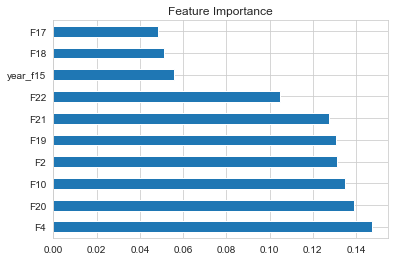

In [29]:
perm_importances = pd.Series(result.importances_mean, index=feature_cols)
perm_importances.nlargest(10).plot(kind='barh', title='Feature Importance')

##### F4 has become the most important feature now and we observed before that F17 and F18 are
##### correlated to F19 and F20 respectively. Also they have very less scores in terms of feature importance
##### therefore we will drop F17 and F18

In [30]:
X = df[feature_cols]
X = X.drop('F17', axis=1)
X = X.drop('F18', axis=1)
X.head()

,F2,F4,F10,F19,F20,F21,F22,year_f15
Index,,,,,,,,
1,0.500340,0.902413,4227810299,706,305,1,2,1986
2,0.281119,0.772159,-1146724819,423,206,18,7,1979
3,0.622005,0.098386,5947184989,703,315,1,4,1989
4,0.957234,0.646479,-5724795826,122,304,15,1,1982
5,0.623008,0.159709,-3097637172,486,240,1,1,1987


#### Splitting the data into train and test

In [31]:

y=df['C']

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.25, random_state=42, stratify=y)

##### Stratified sampling aims at splitting a data set so that each split is similar with respect to something. 
##### In a classification setting, it is often chosen to ensure that the train and test sets have approximately 
##### the same percentage of samples of each target class as the complete set

#### scaling the data

##### Variables that are measured at different scales do not contribute equally to the model fitting & 
##### model learned function and might end up creating a bias. Thus, to deal with this potential problem 
##### feature-wise standardized (μ=0, σ=1) is usually used prior to model fitting.

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train

array([[ 0.70207045,  1.6180477 ,  1.6760912 , ...,  0.71596024,
        -0.75266575, -0.87122301],
       [ 1.19336489,  0.58376634,  0.17337526, ..., -0.54306816,
        -0.75266575, -0.87122301],
       [-0.30249474,  1.68665918,  1.47739977, ...,  0.92579831,
         0.083553  ,  1.12161826],
       ...,
       [ 0.41294744,  0.36039101, -0.71467773, ..., -0.54306816,
         0.91977175,  0.8725131 ],
       [-0.25118916,  1.22812163, -1.05902115, ..., -0.75290623,
        -0.75266575, -0.12390754],
       [-0.14264165,  0.34218893,  1.69385212, ..., -0.12339203,
        -0.33455637,  0.62340794]])

In [33]:

# smt=SMOTE(random_state=10) #FOR CLASS IMBALANCE
# X_train, y_train = smt.fit_sample(X_train, y_train)

#### baseline model - logistic regression --> 75.31% mean accuracy on validation set

In [34]:
model = LogisticRegression(random_state=102)
lr = model.fit(X_train, y_train)
lr

LogisticRegression(random_state=102)

In [35]:
lr.classes_

array([0, 1])

In [36]:
lr.intercept_ #array([-0.23622246])


array([-1.19416782])

In [37]:
lr.coef_

array([[-0.06291684,  0.09359142,  0.01586145, -0.37281788, -0.36323801,
        -0.04533788, -0.03757444,  0.00251492]])

In [38]:
lr_probs = lr.predict_proba(X_test)[:,1]
lr_probs

array([0.20101222, 0.18622723, 0.25267764, ..., 0.30481113, 0.4211243 ,
       0.18590166])

In [39]:
lr_score = lr.score(X_test, y_test) 
lr_score

0.7531132634908084

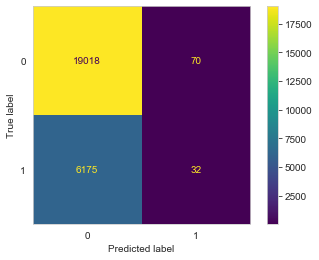

In [40]:
lr_preds = lr.predict(X_test)
cm = confusion_matrix(y_test, lr_preds)

plot_confusion_matrix(lr, X_test, y_test)
plt.grid(b=None)
plt.show()

In [41]:
cr_lr = classification_report(y_test, lr_preds)
print(cr_lr)

              precision    recall  f1-score   support

           0       0.75      1.00      0.86     19088
           1       0.31      0.01      0.01      6207

    accuracy                           0.75     25295
   macro avg       0.53      0.50      0.43     25295
weighted avg       0.65      0.75      0.65     25295



##### If we look at the classification report, it is able to predict class 0 with a good recall 
##### but the same is impacted in case of class 1 where recall is only (0.01). We will use
##### something called SMOTe to address this issue

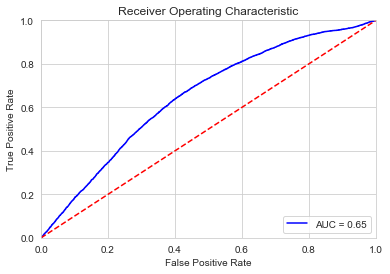

In [42]:
roc_auc = roc_auc_score(y_test, lr_probs)

fpr, tpr, thresholds = roc_curve(y_test, lr_probs) 
plt.figure()
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### Using a random forest to check if we can do better than the baseline

In [43]:
rf_model = RandomForestClassifier(random_state=101)
rf_model.fit(X_train,y_train)
print("Training accuracy",rf_model.score(X_train,y_train))
print("Test accuracy",rf_model.score(X_test,y_test))

Training accuracy 0.9999604664953549
Test accuracy 0.7479739078869342


##### The above model overfits on training data with accuracy as 0.9999, 
##### hence we add the parameter `min_impurity_decrease` to tackle overfitting on training data

In [44]:
rf_model_2 = RandomForestClassifier(random_state=202, min_impurity_decrease=0.1)
rf_model_2.fit(X_train,y_train)
print("Training accuracy",rf_model_2.score(X_train,y_train))
print("Test accuracy",rf_model_2.score(X_test,y_test))

Training accuracy 0.7546287145022073
Test accuracy 0.7546155366673255


In [45]:
# Trying a RandomForestClassifier with lesser overfitting
# param_test1 = {
#  'max_features':range(1,8,1)
# }
# gsearch1 = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_test1, 
#                         scoring='f1',n_jobs=-1,iid=False, cv=3, verbose=10)
# gsearch1.fit(X_train, y_train)
# gsearch1.best_params_, gsearch1.best_score_
# ({'max_depth': 10, 'n_estimators': 1}, 0.06902616703164123)


In [46]:
# Using Random forest with max_depth:10 and n_estimators:1
rf_model_3 = RandomForestClassifier(random_state=404, max_depth=10, n_estimators=1, max_features=6)
rf_model_3.fit(X_train,y_train)
print("Training accuracy",rf_model_3.score(X_train,y_train))
print("Test accuracy",rf_model_3.score(X_test,y_test))

Training accuracy 0.7572247479739079
Test accuracy 0.7466297687289978


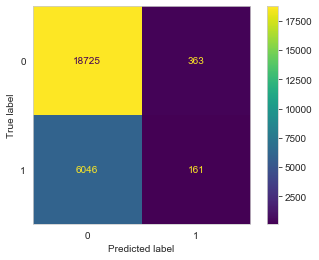

In [47]:
rf3_preds = rf_model_3.predict(X_test)
cm = confusion_matrix(y_test, rf3_preds)

plot_confusion_matrix(rf_model_3, X_test, y_test)
plt.grid(b=None)
plt.show()

In [48]:
cr_rf3 = classification_report(y_test, rf3_preds)
print(cr_rf3)

              precision    recall  f1-score   support

           0       0.76      0.98      0.85     19088
           1       0.31      0.03      0.05      6207

    accuracy                           0.75     25295
   macro avg       0.53      0.50      0.45     25295
weighted avg       0.65      0.75      0.66     25295



##### Using paramters from GridSearchCV we are able to compensate 
##### somewhat for the impacted scores of class 1. 
##### We are able to improve the F1-score from 0.65 to 0.66

##### using smote to tackle imbalance

In [49]:
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21, stratify=y)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (75885, 8)
Number transactions y_train dataset:  (75885,)
Number transactions X_test dataset:  (25295, 8)
Number transactions y_test dataset:  (25295,)


In [50]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=200)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 18620
Before OverSampling, counts of label '0': 57265 

After OverSampling, the shape of train_X: (114530, 8)
After OverSampling, the shape of train_y: (114530,) 

After OverSampling, counts of label '1': 57265
After OverSampling, counts of label '0': 57265


In [51]:
rfc_smoted = RandomForestClassifier(random_state=505, max_depth=10, n_estimators=1, max_features=6)
rfc_smoted.fit(X_train_res, y_train_res)
rfc_smoted
print("Training accuracy",rfc_smoted.score(X_train_res,y_train_res))
print("Test accuracy",rfc_smoted.score(X_test,y_test))

Training accuracy 0.7273116214092378
Test accuracy 0.6200039533504645


In [52]:
rfc_smt_probs = rfc_smoted.predict_proba(X_test)[:,1]
rfc_smt_probs

array([0.04150943, 0.72985792, 0.00993789, ..., 0.72985792, 0.36935167,
       0.01712329])

In [53]:
rfc_smt_score = rfc_smoted.score(X_test, y_test) 
rfc_smt_score

0.6200039533504645

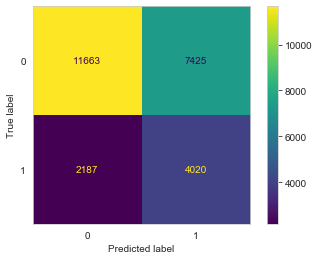

In [54]:
rfc_smt_preds = rfc_smoted.predict(X_test)

plot_confusion_matrix(rfc_smoted, X_test, y_test)
plt.grid(b=None)
plt.show()

In [55]:
cr_rfc_smt = classification_report(y_test, rfc_smt_preds)
print(cr_rfc_smt)

              precision    recall  f1-score   support

           0       0.84      0.61      0.71     19088
           1       0.35      0.65      0.46      6207

    accuracy                           0.62     25295
   macro avg       0.60      0.63      0.58     25295
weighted avg       0.72      0.62      0.65     25295



               precision    recall  f1-score   support

           0       0.76      0.98      0.85     19088
           1       0.31      0.03      0.05      6207

    accuracy                           0.75     25295
    
   macro avg       0.53      0.50      0.45     25295
   
weighted avg       0.65      0.75      0.66     25295

##### If you compare this with the previous classifiaction report, it is evident that the 
##### accuracy of model is decreased from 75 to 62, but we see a significant imporvement
##### of recall for class 1 from 0.03 to 0.65. This has resulted in a better f1-score and
##### overall recall of the model for both the classes

##### We will also try to use XGBoost to see if we can get any imporvements
##### `NOTE`: The Hyperparameter tuning blocks are commented and the final set of 
##### selected parameters are present in the nexr cell.

In [56]:
# Hyperparameter tuning for XGBoost
# param_test1 = {
#  'max_depth':range(7,17,2),
#  'min_child_weight':range(1,6,2)
# }

# gsearch1 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5, min_child_weight=1, 
#                                                 gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', 
#                                                 nthread=4, scale_pos_weight=1, seed=27), 
#                         param_grid = param_test1, 
#                         scoring='f1',
#                         n_jobs=-1,
#                         verbose=10,
#                         cv=3)
# gsearch1.fit(X_train_res, y_train_res)
# gsearch1.best_params_, gsearch1.best_score_
# ({'max_depth': 15, 'min_child_weight': 1}, 0.7412811190331731)

# Fitting 3 folds for each of 15 candidates, totalling 45 fits
# [Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
# [Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.7min
# [Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.4min
# [Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  5.6min
# [Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 11.2min
# [Parallel(n_jobs=-1)]: Done  35 out of  45 | elapsed: 17.3min remaining:  4.9min
# [Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed: 19.5min remaining:  2.4min
# [Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 21.9min remaining:    0.0s
# [Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 21.9min finished

In [57]:
# param_test3 = {
#  'gamma':[i/10.0 for i in range(0,5)]
# }
# gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=9, min_child_weight=1, 
#                                                    gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', 
#                                                    nthread=4, scale_pos_weight=1, seed=27), 
#                         param_grid = param_test3, 
#                         scoring='f1',
#                         n_jobs=-1,
#                         verbose=10,
#                         cv=3)
# gsearch3.fit(X_train_res, y_train_res)
# gsearch3.best_params_, gsearch3.best_score_
# ({'gamma': 0.2}, 0.7317720488079312)

# Fitting 3 folds for each of 5 candidates, totalling 15 fits
# [Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
# [Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:  2.8min remaining: 18.1min
# [Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  2.8min remaining:  7.7min
# [Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  2.8min remaining:  4.3min
# [Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  2.9min remaining:  2.5min
# [Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  5.6min remaining:  2.8min
# [Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  5.6min remaining:  1.4min
# [Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  5.7min finished

In [58]:
# param_test5 = {
#  'subsample':[i/100.0 for i in range(75,90,5)],
#  'colsample_bytree':[i/100.0 for i in range(75,90,5)]
# }
# gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=9, min_child_weight=1, 
#                                                   gamma=0.4, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic',
#                                                   nthread=4, scale_pos_weight=1, seed=27), 
#                         param_grid = param_test5, 
#                         scoring='f1',
#                         n_jobs=-1,
#                         verbose=10,
#                         cv=3)
# gsearch5.fit(X_train_res, y_train_res)
# gsearch5.best_params_, gsearch5.best_score_

# ({'colsample_bytree': 0.75, 'subsample': 0.85}, 0.7303327771301836)

# [Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
# [Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.6min
# [Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  7.6min
# [Parallel(n_jobs=-1)]: Done  15 out of  27 | elapsed:  7.8min remaining:  6.2min
# [Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed: 10.9min remaining:  5.4min
# [Parallel(n_jobs=-1)]: Done  21 out of  27 | elapsed: 10.9min remaining:  3.1min
# [Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed: 11.0min remaining:  1.4min
# [Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 11.7min remaining:    0.0s
# [Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 11.7min finished

In [59]:
# param_test7 = {
#  'reg_lambda':[0, 0.001, 0.005, 0.01, 0.05]
# }
# gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=9, min_child_weight=1, 
#                                                    gamma=0.4, subsample=0.8, colsample_bytree=0.75, objective= 'binary:logistic',
#                                                    nthread=4, scale_pos_weight=1,seed=27), 
#                         param_grid = param_test7, 
#                         scoring='f1',
#                         n_jobs=-1,
#                         verbose=10, 
#                         cv=3)
# gsearch7.fit(X_train_res, y_train_res)
# gsearch7.best_params_, gsearch7.best_score_

# ({'reg_lambda': 0}, 0.730650625802375)


In [60]:
# param_test8 = {
#  'n_estimators':range(100, 2000, 100)
# }
# gsearch8 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, max_depth=9, min_child_weight=1, 
#                                                    gamma=0.4, subsample=0.8, colsample_bytree=0.75, objective= 'binary:logistic',
#                                                    nthread=4, scale_pos_weight=1,seed=27), 
#                         param_grid = param_test8, 
#                         scoring='f1',
#                         n_jobs=-1,
#                         verbose=10, 
#                         cv=3)
# gsearch8.fit(X_train_res, y_train_res)
# gsearch8.best_params_, gsearch8.best_score_
# ({'n_estimators': 1900}, 0.7476227100272009)

# Fitting 3 folds for each of 19 candidates, totalling 57 fits
# [Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
# [Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.7min
# [Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  8.7min
# [Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 19.3min
# [Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 38.7min
# [Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 66.5min
# [Parallel(n_jobs=-1)]: Done  48 out of  57 | elapsed: 119.6min remaining: 22.4min
# [Parallel(n_jobs=-1)]: Done  54 out of  57 | elapsed: 146.8min remaining:  8.2min
# [Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed: 151.1min finished

#### Putting all the best parameters from above exercise in our final classifier

In [156]:
# scaling the data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)
X_train_res

array([[ 1.6340789 , -1.05606476, -0.54770932, ...,  2.58956738,
         1.47581319,  0.43433243],
       [ 0.58326237, -0.81661204, -0.99022373, ...,  0.35331701,
        -0.76621135, -0.62331555],
       [ 1.31967096, -1.30871766,  1.51201657, ..., -0.76480817,
        -0.76621135, -1.68096353],
       ...,
       [ 0.3599385 , -0.59590138,  0.44915674, ...,  0.35331701,
        -0.09360399,  0.43433243],
       [ 1.50826009,  0.15508167, -0.48945568, ...,  0.12969198,
        -0.31780644, -0.09449156],
       [-0.15308176, -0.3955264 ,  0.91907473, ..., -0.76480817,
        -0.54200889, -0.09449156]])

In [157]:
# set verbosity=0 if required silent training
xgb = XGBClassifier(learning_rate=0.01, n_estimators=1900, max_depth=15, min_child_weight=1, gamma=0.2, subsample=0.85, 
                    colsample_bytree=0.75, reg_lambda=0, objective= 'binary:logistic', nthread=4, verbosity=0, n_jobs=-1
                    , random_state=2020)

xgb.fit(X_train_res, y_train_res)

ypred = xgb.predict(X_test)
pred_prob = xgb.predict_proba(X_test)[:,1]

# recall_score(ypred, y_test)
accuracy_score(ypred, y_test) 
# 0.6515121565526784

0.6507610199644198

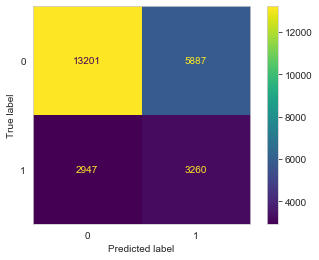

In [158]:
plot_confusion_matrix(xgb, X_test, y_test)
plt.grid(b=None)
plt.show()

In [159]:
cr_xgb = classification_report(y_test, ypred)
print(cr_xgb)

              precision    recall  f1-score   support

           0       0.82      0.69      0.75     19088
           1       0.36      0.53      0.42      6207

    accuracy                           0.65     25295
   macro avg       0.59      0.61      0.59     25295
weighted avg       0.70      0.65      0.67     25295



##### We can observe that the average f1 score is now imporved using XGB
##### compared to the baseline Logistic Regression Model and the Random
##### Forest classifier trained using SMOTe

#### Receiver Operating Characteristic

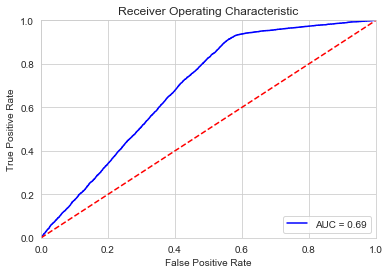

In [160]:
roc_auc = roc_auc_score(y_test, pred_prob)

fpr, tpr, thresholds = roc_curve(y_test, pred_prob) 
plt.figure()
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Significant Features of the Final Model

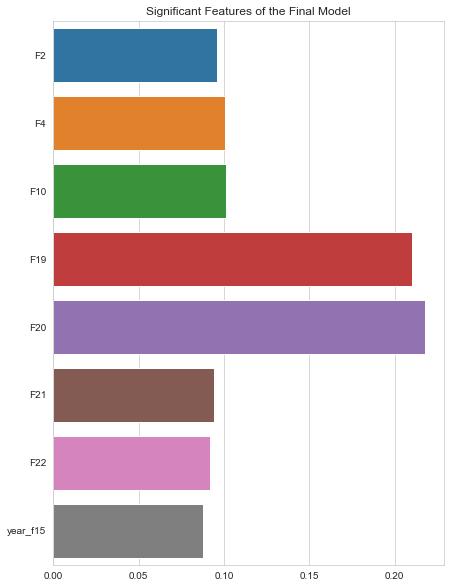

In [161]:
plt.figure(figsize=(7,10))
sns.barplot(x=xgb.feature_importances_,y=X.columns)
plt.title('Significant Features of the Final Model')
plt.show()

#### 2-class Precision-Recall curve

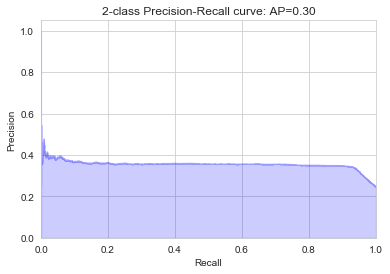

In [162]:
pred_prob = xgb.predict_proba(X_test)[:,1]

# Get average precision
average_precision = average_precision_score(y_test, ypred)
# Plot PR
precision, recall, _ = precision_recall_curve(y_test, pred_prob)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.savefig('XGBoost_PR')
plt.show()

#### Generating submission files

In [167]:
# Reading the training file again 
train_two = pd.read_csv('Dataset.txt', sep="\t", header=0, low_memory=False, dtype={'C':'int'}, index_col='Index')
X = train_two.drop('C', axis=1)

# breaking down time attributes
X['F15'] = pd.to_datetime(X['F15']) 
X['F16'] = pd.to_datetime(X['F16']) 

X['year_f15'] = X['F15'].dt.year
X['month_f15'] = X['F15'].dt.month
X['week_f15'] = X['F15'].dt.week
X['day_f15'] = X['F15'].dt.day_name()

le = LabelEncoder()
X['month_f15'] = le.fit_transform(X['month_f15'])
X['day_f15'] = le.fit_transform(X['day_f15'])

X['year_f16'] = X['F16'].dt.year

# dropping insignificant features
X = X.drop(not_sgfnt, axis=1)

# dropping `F17` and `F18`
X = X.drop('F17', axis=1)
X = X.drop('F18', axis=1)

y = train_two['C']

print(X.shape, y.shape)
# print(not_sgfnt)


(101180, 8) (101180,)


In [168]:
# getting list of columns as used in the model
print(xgb.get_booster().feature_names, X.columns)
cols_as_in_model = xgb.get_booster().feature_names

['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7'] Index(['F2', 'F4', 'F10', 'F19', 'F20', 'F21', 'F22', 'year_f15'], dtype='object')


In [169]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_copy = scaler.fit_transform(X_copy)
X_copy

array([[-0.00400258,  1.39430314,  0.72960425, ..., -0.75131828,
        -0.544035  , -0.37495074],
       [-0.7625128 ,  0.94317161, -0.20201337, ...,  2.80840847,
         0.50276313, -2.11933037],
       [ 0.41696341, -1.39041951,  1.02763928, ..., -0.75131828,
        -0.12531574,  0.37264053],
       ...,
       [ 0.07048947,  1.31492238,  0.90332569, ..., -0.54192259,
        -0.12531574,  0.12344344],
       [ 0.15468504,  1.05738974,  0.02743034, ..., -0.75131828,
        -0.75339462, -2.11933037],
       [-1.08615683,  0.3776747 , -1.53473071, ..., -0.12313121,
        -0.75339462, -2.11933037]])

In [170]:
train_submission = pd.DataFrame({
    'actual_y': y,
    'predicted_y': xgb.predict(X_copy)
})

train_submission.to_csv("training_preds_new.tsv", sep='\t')

### Conclusion

There were many feature which didn't have significant contribution in the predictive power of the classifier.

The uniform distribution in the numerical features had an impact on classification, as observed in the final confusion matrix

Transfomring the date column into year column proved a useful features, as observed in the feature importance plot as well

F19 and F20 are some of the powerful features which proved as very good predictors

# Test File:

In [171]:
df_test = pd.read_csv('Dataset_test.txt', sep="\t", header=0, low_memory=False, dtype={'C':'int'}, index_col='Index')

In [172]:
df_test.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22
Index,,,,,,,,,,,,,,,,,,,,,,
T30234341,0.654765,0.812009,0.603190,0.391039,-5220,4825,-1784,7447,-7147,-3461806391,8178108368,-8674321652,8074343777,5553595074,9/17/1996,8/18/1990,1,1,436,478,1,1
T30234342,0.694636,0.690568,0.473460,0.259760,-618,-5018,2012,9259,9267,-36253473,-6531193961,1849753082,-5556861821,2216284070,11/7/1985,4/11/1990,1,1,138,56,10,4
T30234343,0.203759,0.323301,0.492294,0.011448,-8778,6141,6965,3774,4303,5354243488,8053401796,782597920,-2121815725,-315409510,7/9/1984,5/4/1997,1,1,117,323,10,1
T30234344,0.319627,0.286247,0.906197,0.093840,-7929,4471,7715,9543,335,7405036171,-2666864618,-8649240595,1389754605,-3360224957,6/3/1987,7/1/1988,1,1,115,149,16,21
T30234345,0.236003,0.782784,0.285689,0.383585,-3296,4564,-1580,-8559,-27,-6351599280,-2152422738,4768902493,3653338555,7604838279,7/17/1984,12/3/1993,1,1,527,281,3,1


In [173]:
missing_data(df_test)

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Types,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,object,int64,int64,int64,int64,int64,int64


In [174]:
# converting date columns to date type
df_test['F15'] = pd.to_datetime(df_test['F15']) 
df_test['F16'] = pd.to_datetime(df_test['F16']) 

df_test['year_f15'] = df_test['F15'].dt.year
df_test['month_f15'] = df_test['F15'].dt.month
df_test['week_f15'] = df_test['F15'].dt.week
df_test['day_f15'] = df_test['F15'].dt.day_name()

le = LabelEncoder()
df_test['month_f15'] = le.fit_transform(df_test['month_f15'])
df_test['day_f15'] = le.fit_transform(df_test['day_f15'])

df_test['year_f16'] = df_test['F16'].dt.year

In [175]:
df_test.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,year_f15,month_f15,week_f15,day_f15,year_f16
Index,,,,,,,,,,,,,,,,,,,,,,,,,,,
T30234341,0.654765,0.812009,0.603190,0.391039,-5220,4825,-1784,7447,-7147,-3461806391,8178108368,-8674321652,8074343777,5553595074,1996-09-17,1990-08-18,1,1,436,478,1,1,1996,8,38,5,1990
T30234342,0.694636,0.690568,0.473460,0.259760,-618,-5018,2012,9259,9267,-36253473,-6531193961,1849753082,-5556861821,2216284070,1985-11-07,1990-04-11,1,1,138,56,10,4,1985,10,45,4,1990
T30234343,0.203759,0.323301,0.492294,0.011448,-8778,6141,6965,3774,4303,5354243488,8053401796,782597920,-2121815725,-315409510,1984-07-09,1997-05-04,1,1,117,323,10,1,1984,6,28,1,1997
T30234344,0.319627,0.286247,0.906197,0.093840,-7929,4471,7715,9543,335,7405036171,-2666864618,-8649240595,1389754605,-3360224957,1987-06-03,1988-07-01,1,1,115,149,16,21,1987,5,23,6,1988
T30234345,0.236003,0.782784,0.285689,0.383585,-3296,4564,-1580,-8559,-27,-6351599280,-2152422738,4768902493,3653338555,7604838279,1984-07-17,1993-12-03,1,1,527,281,3,1,1984,6,29,5,1993


In [176]:
df_test = df_test.drop(not_sgfnt, axis=1)
df_test = df_test.drop('F17', axis=1)
df_test = df_test.drop('F18', axis=1)
df_test.head()

,F2,F4,F10,F19,F20,F21,F22,year_f15
Index,,,,,,,,
T30234341,0.812009,0.391039,-3461806391,436,478,1,1,1996
T30234342,0.690568,0.259760,-36253473,138,56,10,4,1985
T30234343,0.323301,0.011448,5354243488,117,323,10,1,1984
T30234344,0.286247,0.093840,7405036171,115,149,16,21,1987
T30234345,0.782784,0.383585,-6351599280,527,281,3,1,1984


In [177]:
x = df_test.copy()

In [181]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x = scaler.fit_transform(x)
x

array([[ 1.07940802e+00, -3.75007398e-01, -5.94248838e-01, ...,
        -7.60685803e-01, -7.52957342e-01,  2.12295887e+00],
       [ 6.58070154e-01, -8.30729772e-01, -1.70081497e-03, ...,
         1.12203520e+00, -1.20073988e-01, -6.20873839e-01],
       [-6.16150840e-01, -1.69271909e+00,  9.30740864e-01, ...,
         1.12203520e+00, -7.52957342e-01, -8.70313177e-01],
       ...,
       [-1.63720589e+00,  3.12361888e-01, -4.09588496e-01, ...,
         4.94461530e-01,  9.08871307e-02,  2.37239821e+00],
       [ 5.26078679e-01, -3.93091550e-01,  4.12719487e-01, ...,
         2.85270308e-01, -1.20073988e-01,  1.62408020e+00],
       [-3.33949928e-01, -1.35278301e+00, -1.86490223e-01, ...,
        -5.51494581e-01, -3.31035106e-01,  1.12520152e+00]])

In [182]:

pred = xgb.predict(x)
# type(x)

In [183]:
pred
type(pred)


df_x = pd.DataFrame(data=pred, index=df_test.index)
df_x.columns = ['predicted_y']
df_x.head()


,predicted_y
Index,
T30234341,1
T30234342,1
T30234343,0
T30234344,0
T30234345,1


In [184]:
df_x.to_csv("testing_preds.tsv", sep='\t')